In [7]:
%matplotlib inline
import pyart
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

In [8]:
radar = pyart.io.read('MDV-20150805-102446-PPIVol.nc')

In [13]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	standard_name: altitude
	units: meters
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (9270,)>
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	units: degrees
	axis: radial_azimuth_coordinate
elevation:
	data: <ndarray of type: float32 and shape: (9270,)>
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	axis: radial_elevation_coordinate
fields:
	DBZH:
		data: <ndarray of type: float32 and shape: (9270, 2500)>
		long_name: equivalent_reflectivity_factor_h
		units: dBZ
		_FillValue: -32768
		coordinates: elevation azimuth range
	DBZV:
		data: <ndarray of type: float32 and shape: (9270, 2500)>
		long_name: equivalent_reflectivity_factor_v
		units: dBZ
		_FillValue: -32768
		coordinates: elevation azimuth range
	VELH:
		data: <ndarray of type: float32 and shape: (9270, 2500)>
		long_name: radial_ve

In [66]:
def check_dimensions(radar, field='DBZH'):
    """
    Check if field dimensions are constants across elevations
    """
    dim0 = radar.fields[field]['data'][radar.get_slice(0)].shape
    for ns in range(0, radar.nsweeps):
        if dim0 != radar.fields[field]['data'][radar.get_slice(ns)].shape:
            raise ValueError("dimension mismatch.")
    return True

In [67]:
cappi_altitude = 2500  # Altitude in m for the CAPPI

In [68]:
# Reshape field into a 3D array (elevation, azimuth, range)
if check_dimensions(radar):
    refl = radar.fields['DBZH']['data'].copy()
    dim0 = refl[radar.get_slice(0)].shape

    ref3dorig = refl.reshape((radar.nsweeps, dim0[0], dim0[1]))
    ref3d = np.zeros_like(ref3dorig)
    
    # Sorting azimuth, put azimuth 0 at index 0, second azimuth at index 1, ...
    for ns in range(radar.nsweeps):
        azi = radar.azimuth['data'][radar.get_slice(ns)]
        pos = np.argsort(azi)    
        for i, p in enumerate(pos):
            ref3d[ns, i, :] = ref3dorig[ns, p, :].copy()

In [69]:
refl[radar.get_slice(0)].shape

(515, 2500)

In [70]:
radar.nsweeps

18

In [71]:
elevation = np.unique(radar.elevation['data'])
r = radar.range['data']
azi = np.linspace(0, 359, dim0[0])

# Convert azimuth to polar
theta = (450 - azi)
theta[theta >= 360] -= 360

THETA, PHI, R = np.meshgrid(theta, elevation, r)

# Radar spherical to cartesian
X = R * np.cos(PHI * np.pi / 180) * np.cos(THETA * np.pi / 180)
Y = R * np.cos(PHI * np.pi / 180) * np.sin(THETA * np.pi / 180)
Z = R * np.sin(PHI * np.pi / 180)

In [100]:
R.shape

(54, 515, 2500)

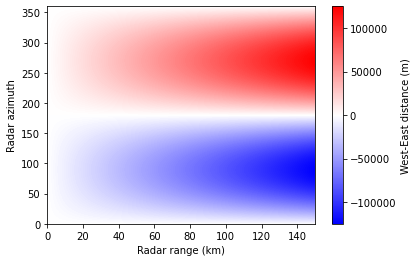

In [72]:
plt.imshow(X[0, :, :], extent=[0, 150, 0, 360], origin='upper', aspect='auto', cmap='bwr')
plt.colorbar(label='West-East distance (m)')
plt.xlabel('Radar range (km)')
plt.ylabel('Radar azimuth')
plt.show()

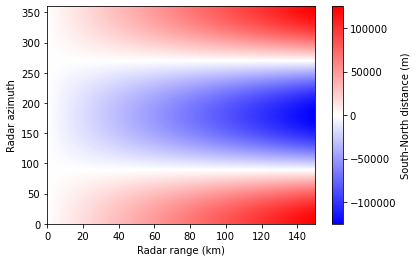

In [73]:
plt.imshow(Y[0, :, :], extent=[0, 150, 0, 360], origin='upper', aspect='auto', cmap='bwr')
plt.colorbar(label='South-North distance (m)')
plt.xlabel('Radar range (km)')
plt.ylabel('Radar azimuth')
plt.show()

In [77]:
posslice = np.argmin(np.abs(Z - cappi_altitude), axis=0)

CAPPI = np.zeros((dim0[0], dim0[1]))
XC = np.zeros((dim0[0], dim0[1]))
YC = np.zeros((dim0[0], dim0[1]))
for i in range(dim0[1]):
    for j in range(dim0[0]):
        CAPPI[j, i] = ref3d[posslice[j, i], j, i]
        XC[j, i] = X[posslice[j, i], j, i]
        YC[j, i] = Y[posslice[j, i], j, i]

IndexError: index 51 is out of bounds for axis 0 with size 18

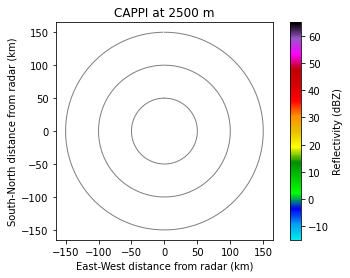

In [28]:
fig, ax = pl.subplots(1, 1)
im = ax.pcolormesh(XC / 1e3, YC / 1e3, CAPPI, cmap='pyart_NWSRef', vmin=-15, vmax=65)
fig.colorbar(im, ax=ax, label='Reflectivity (dBZ)')
[ax.plot(r * np.cos(theta * np.pi / 180), r * np.sin(theta * np.pi / 180), 'k', linewidth=1, alpha=0.5) 
for r in [50, 100, 150]]
ax.set_aspect(1)
ax.set_xlabel('East-West distance from radar (km)')
ax.set_ylabel('South-North distance from radar (km)')
ax.set_title(f'CAPPI at {cappi_altitude} m')
pl.show()

In [105]:
def plot_cappi(radar, field_name, altitude, prdcfg, fname_list,
               beamwidth=1., beam_spacing=1., save_fig=True):
    """
    plots a Constant Altitude Plan Position Indicator CAPPI

    Parameters
    ----------
    radar : Radar object
        object containing the radar data to plot
    field_name : str
        name of the radar field to plot
    altitude : float
        the altitude [m MSL] to be plotted
    prdcfg : dict
        dictionary containing the product configuration
    fname_list : list of str
        list of names of the files where to store the plot
    beamwidth : float
        The radar beamwidth
    beam_spacing : float
        the ray angle resolution
    save_fig : bool
        if true save the figure. If false it does not close the plot and
        returns the handle to the figure

    Returns
    -------
    fname_list : list of str or
    fig, ax : tupple
        list of names of the saved plots or handle of the figure an axes

    """
    norm, ticks, ticklabs = get_norm(field_name)

    xmin = prdcfg['ppiImageConfig']['xmin']
    xmax = prdcfg['ppiImageConfig']['xmax']
    ymin = prdcfg['ppiImageConfig']['ymin']
    ymax = prdcfg['ppiImageConfig']['ymax']

    wfunc = prdcfg.get('wfunc', 'NEAREST')
    cappi_res = prdcfg.get('res', 500.)

    # number of grid points in cappi
    ny = int((ymax-ymin)*1000./cappi_res)+1
    nx = int((xmax-xmin)*1000./cappi_res)+1

    # parameters to determine the gates to use for each grid point
    if (radar.instrument_parameters is not None and
            'radar_beam_width_h' in radar.instrument_parameters):
        beamwidth = radar.instrument_parameters[
            'radar_beam_width_h']['data'][0]

    if radar.ray_angle_res is not None:
        beam_spacing = radar.ray_angle_res['data'][0]

    lat = float(radar.latitude['data'])
    lon = float(radar.longitude['data'])
    alt = 0.

    # cartesian mapping
    grid = pyart.map.grid_from_radars(
        (radar,), gridding_algo='map_to_grid', weighting_function=wfunc,
        roi_func='dist_beam', h_factor=1.0, nb=beamwidth, bsp=beam_spacing,
        min_radius=cappi_res/2.,
        grid_shape=(1, ny, nx),
        grid_limits=((altitude, altitude), (ymin*1000., ymax*1000.),
                     (xmin*1000., xmax*1000.)),
        grid_origin=(lat, lon), grid_origin_alt=alt,
        fields=[field_name])

    # display data
    dpi = prdcfg['ppiImageConfig'].get('dpi', 72)

    fig = plt.figure(figsize=[prdcfg['ppiImageConfig']['xsize'],
                              prdcfg['ppiImageConfig']['ysize']],
                     dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    cmap = pyart.config.get_field_colormap(field_name)

    vmin = vmax = None
    if norm is None:  # if norm is set do not override with vmin/vmax
        vmin, vmax = pyart.config.get_field_limits(field_name)

    titl = pyart.graph.common.generate_grid_title(grid, field_name, 0)

    cax = ax.imshow(
        grid.fields[field_name]['data'][0], extent=(xmin, xmax, ymin, ymax),
        origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, norm=norm,
        interpolation='none')
    ax.set_xlabel('East West distance from radar(km)')
    ax.set_ylabel('North South distance from radar(km)')
    ax.set_title(titl)

    # plot the colorbar and set the label.
    cb = fig.colorbar(cax)
    if ticks is not None:
        cb.set_ticks(ticks)
    if ticklabs:
        cb.set_ticklabels(ticklabs)
    label = get_colobar_label(grid.fields[field_name], field_name)
    cb.set_label(label)

    # Make a tight layout
    fig.tight_layout()

    if save_fig:
        for fname in fname_list:
            fig.savefig(fname, dpi=dpi)
        plt.close(fig)

        return fname_list

    return (fig, ax)


In [111]:
plot_cappi(radar,'DBZH',2500,'mch_cfg.py2222','Users/rizvi/Documents/Project/Jup')

NameError: name 'get_norm' is not defined